<a href="https://colab.research.google.com/github/FadouaKhm/CSE590-Spring21-Intro-to-ML-DL/blob/main/%5BIntro_to_ML%5Dsklearn_data_representation_matters.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Objectives
* Perform multi-class classification on the extracted features using different settings.
   1. Classification
   2. PCA + Classification
   3. Feature selection + Classification
   4. Clustering analysis

* Compare and analyze results

## Dataset - kmnist
**Description:** 
Kuzushiji-MNIST is a drop-in replacement for the MNIST dataset (28x28 grayscale, 70,000 images), provided in the original MNIST format as well as a NumPy format. Since MNIST restricts us to 10 classes, we chose one character to represent each of the 10 rows of Hiragana when creating Kuzushiji-MNIST.

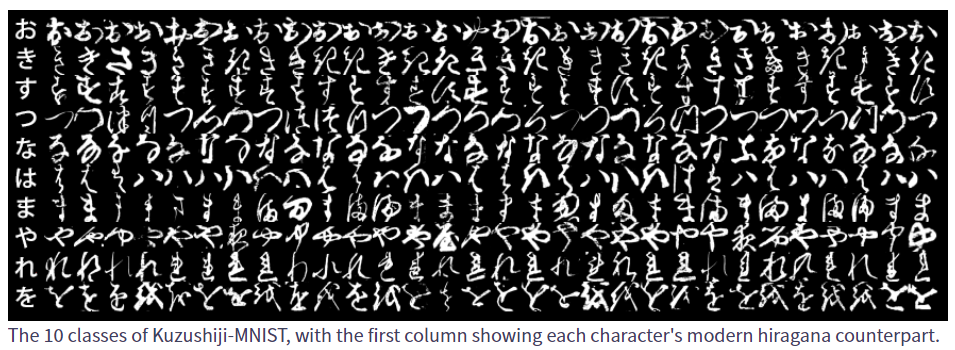

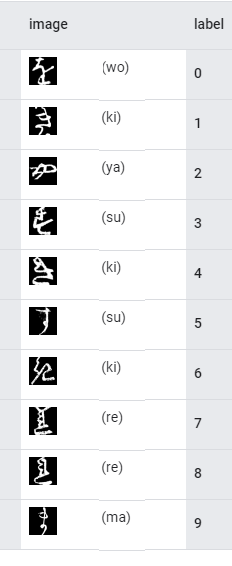

## Load the data

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


features = pd.read_csv('/content/drive/MyDrive/PhD Research/TA/Lab 5 - data/features.csv', index_col=False, header=None)
labels = pd.read_csv('/content/drive/MyDrive/PhD Research/TA/Lab 5 - data/labels.csv', index_col=False, header=None)
images = pd.read_csv('/content/drive/MyDrive/PhD Research/TA/Lab 5 - data/images.csv', index_col=False, header=None)

classes = ['c0','c1', 'c2', 'c3', 'c4', 'c5', 'c6','c7', 'c8', 'c9' ]

In [42]:
features.shape, labels.shape, images.shape

((5000, 64), (5000, 1), (5000, 784))

In [43]:
features.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.0,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,2.473468,7.899903,12.862493,10.997185,15.581064,0.001295,0.002852,7.851175,9.560532,10.130068,0.200431,6.231337,8.340207,4.047074,12.152919,8.587639,12.626447,7.947588,8.756629,0.015375,13.048859,0.008907,0.023999,3.210110,12.176189,0.000446,9.474023,10.223723,0.000798,0.010379,0.790072,1.376905,5.233931,12.737316,0.002006,0.079457,7.506611,1.539073,0.012117,6.169712,16.045419,10.054142,11.522063,13.972238,2.157437,0.395175,0.0,9.051849,0.004675,11.115344,10.870941,11.970618,11.272253,12.260874,0.504059,7.964403,7.045159,0.000759,1.123882,9.985430,3.974270,3.137771,9.840096,8.875896
std,3.595935,6.095234,8.346563,7.195108,8.439649,0.046484,0.112351,7.372739,6.892674,6.490946,0.814731,7.540494,5.993773,6.087216,10.573022,6.557658,6.378523,5.747364,6.588320,0.245989,6.568383,0.134340,0.257901,5.008815,6.610928,0.029612,7.036879,6.848165,0.033248,0.153886,1.982244,2.687096,7.277507,5.305206,0.064858,0.685427,6.610885,3.475967,0.177944,6.277494,7.771879,7.121756,7.104010,8.608674,4.231715,1.273162,0.0,7.531243,0.076768,6.536677,6.021156,7.820775,6.722729,8.100365,1.667873,6.223110,6.702756,0.032102,2.338871,7.772419,5.735661,5.153179,6.904972,6.347787
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2.787162,5.979184,5.071085,9.778203,0.000000,0.000000,0.279012,4.202781,5.060356,0.000000,0.000000,3.653775,0.000000,3.823723,2.929258,8.226063,3.192503,3.971601,0.000000,8.472011,0.000000,0.000000,0.000000,7.366899,0.000000,3.559361,4.907042,0.000000,0.000000,0.000000,0.000000,0.000000,8.993936,0.000000,0.000000,2.213798,0.000000,0.000000,0.031250,10.626887,4.183690,6.353299,7.198528,0.000000,0.000000,0.0,2.290288,0.000000,6.216683,6.447355,5.647544,6.000438,5.935429,0.000000,2.989953,0.000000,0.000000,0.000000,3.696474,0.000000,0.000000,4.167034,3.401691
50%,0.151617,7.410969,12.360599,10.951422,14.722627,0.000000,0.000000,6.635683,9.037389,9.580279,0.000000,3.414377,7.701368,0.801291,10.081330,7.822480,12.304538,7.627013,7.763850,0.000000,13.029535,0.000000,0.000000,0.000000,12.078423,0.000000,8.826988,9.576417,0.000000,0.000000,0.000000,0.000000,1.247304,12.557979,0.000000,0.000000,6.191860,0.000000,0.000000,4.469836,15.779419,9.368968,10.679614,14.015077,0.000000,0.000000,0.0,8.073977,0.000000,11.484732,10.752111,11.324721,11.357126,11.026855,0.000000,7.278444,5.798202,0.000000,0.000000,8.455521,0.394612,0.000000,9.157927,8.887079
75%,4.194467,11.808888,18.784061,16.567699,21.161212,0.000000,0.000000,12.960014,14.022925,14.598616,0.000000,9.979087,12.392262,5.8849

Text(0.5, 1.0, 'class distribution')

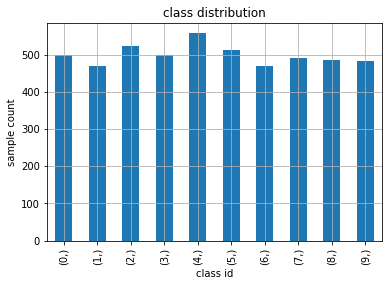

In [44]:
# check the classes distribution
labels.value_counts(sort=False).plot(kind='bar')
plt.grid()
plt.xlabel('class id')
plt.ylabel('sample count')
plt.title('class distribution')
#plt.xticks(range(len(classes)),np.array(classes), rotation=90)

## Split the data into training and testing

In [45]:
from sklearn.model_selection import train_test_split

indices = np.arange(len(features))

X_train, X_test, y_train, y_test, idx1, idx2 = train_test_split(features.values, labels.values, indices, random_state=100, test_size=0.2 )

img_train = images.values[idx1,:] # training images
img_test = images.values[idx2,:] # testing images

y_train = y_train.ravel()
y_test = y_test.ravel()

In [46]:
X_train.shape, y_train.shape, img_train.shape

((4000, 64), (4000,), (4000, 784))

In [47]:
X_test.shape, y_test.shape, img_test.shape

((1000, 64), (1000,), (1000, 784))

## Classification

In [48]:
from sklearn.preprocessing import StandardScaler, RobustScaler,MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import GridSearchCV

In [49]:
from sklearn.pipeline import Pipeline
dt_pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('classifier',DecisionTreeClassifier(random_state=15))
        ])

In [50]:
dt_pipe.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'scaler', 'classifier', 'scaler__copy', 'scaler__with_mean', 'scaler__with_std', 'classifier__ccp_alpha', 'classifier__class_weight', 'classifier__criterion', 'classifier__max_depth', 'classifier__max_features', 'classifier__max_leaf_nodes', 'classifier__min_impurity_decrease', 'classifier__min_impurity_split', 'classifier__min_samples_leaf', 'classifier__min_samples_split', 'classifier__min_weight_fraction_leaf', 'classifier__presort', 'classifier__random_state', 'classifier__splitter'])

In [52]:
scalers_to_test = [StandardScaler(), RobustScaler(), MinMaxScaler()]

params = {'scaler': scalers_to_test,
        'classifier__max_depth': [2, 5,10, 20,30, 40, 50],\
        'classifier__criterion': ['gini', 'entropy'],
        'classifier__max_features':  ['auto', 'sqrt', 'log2']}

In [53]:
# Find best parameters using grid search
dt_clf = GridSearchCV(dt_pipe, params, cv=3,verbose=1)
#Fit model
dt_clf.fit(X_train,y_train)

Fitting 3 folds for each of 126 candidates, totalling 378 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 378 out of 378 | elapsed:   14.3s finished


GridSearchCV(cv=3, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('scaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('classifier',
                                        DecisionTreeClassifier(ccp_alpha=0.0,
                                                               class_weight=None,
                                                               criterion='gini',
                                                               max_depth=None,
                                                               max_features=None,
                                                               max_leaf_nodes=None,
                                                               min_impurity_decrease=0.0,
                              

In [54]:
print(dt_clf.best_params_)

{'classifier__criterion': 'gini', 'classifier__max_depth': 10, 'classifier__max_features': 'auto', 'scaler': StandardScaler(copy=True, with_mean=True, with_std=True)}


In [55]:
print("Training score = ", dt_clf.score(X_train, y_train))
print("Testing score = ", dt_clf.score(X_test, y_test))

Training score =  0.9355
Testing score =  0.821


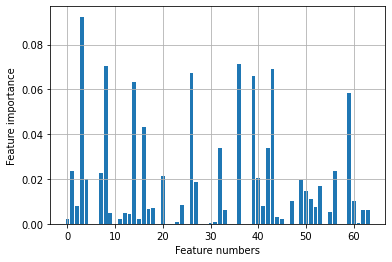

In [56]:
#Feature importance
importance_dt = dt_clf.estimator['classifier'].fit(X_train,y_train).feature_importances_
plt.bar(np.arange(len(importance_dt)), importance_dt)

plt.xlabel("Feature numbers")
plt.ylabel("Feature importance")
plt.grid()

## PCA + Classification



In [57]:
# standardize the data
scaler = StandardScaler().fit(X_train)

X_train_s = scaler.transform(X_train)
X_test_s = scaler.transform(X_test)

In [58]:
clf_pca = DecisionTreeClassifier(random_state=15, max_features='auto', max_depth=10, criterion='gini')

In [59]:
## PCA

from sklearn.decomposition import PCA

In [60]:
pca = PCA(n_components=32).fit(X_train_s)
explained_var = pca.explained_variance_ratio_
sum(explained_var)

0.8778593860301247

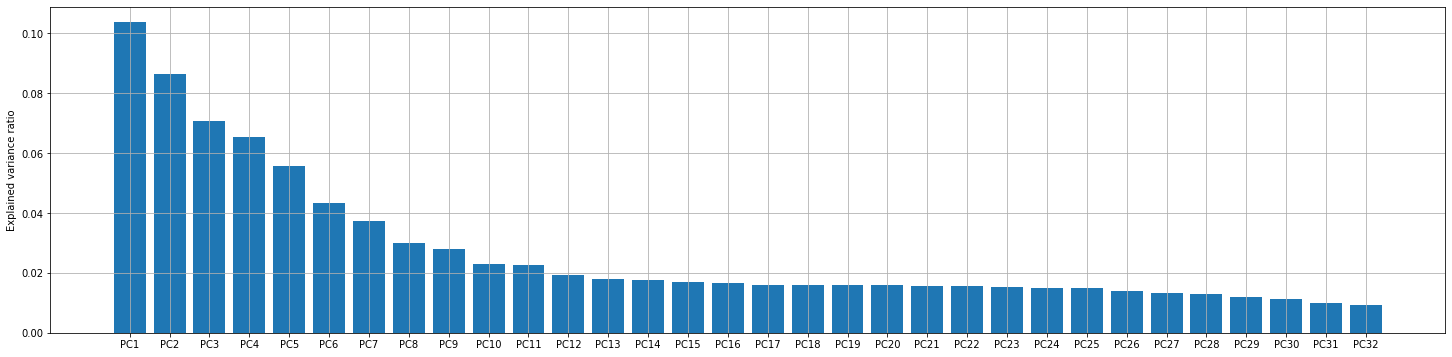

In [61]:
plt.figure(figsize=(25,6))
plt.bar(["PC{}".format(i) for i in range(1,len(explained_var)+1)], pca.explained_variance_ratio_)
plt.ylabel("Explained variance ratio")
plt.grid()

In [62]:
# Transform training and testing data using PCA
X_train_pca = pca.transform(X_train_s)
X_test_pca = pca.transform(X_test_s)

In [63]:
clf_pca.fit(X_train_pca,y_train)

print('#### Without fine tuning ####')
print("Training  score = ", clf_pca.score(X_train_pca, y_train))
print(" Testing score = ", clf_pca.score(X_test_pca, y_test))


#### Without fine tuning ####
Training  score =  0.91275
 Testing score =  0.816


## Feature selection + Classification

**Model-Based FS** Model-based FS considers all features at once and can capture
interactions.

In [64]:
from sklearn.feature_selection import SelectFromModel

select = SelectFromModel(DecisionTreeClassifier(random_state=15, max_depth=10, criterion='gini', max_features='auto'), threshold="median")

In [65]:
clf_FS = DecisionTreeClassifier(random_state=15, max_features='auto', max_depth=10, criterion='gini')

In [68]:
select.fit(X_train_s, y_train)
X_train_l1 = select.transform(X_train_s)
X_test_l1 = select.transform(X_test_s)
print("X_train.shape: {}".format(X_train_s.shape))
print("X_train_l1.shape: {}".format(X_train_l1.shape))

X_train.shape: (4000, 64)
X_train_l1.shape: (4000, 32)


([], <a list of 0 Text major ticklabel objects>)

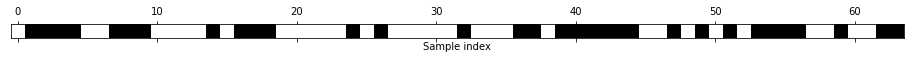

In [69]:
mask = select.get_support()
# visualize the mask -- black is True, white is False
plt.matshow(mask.reshape(1, -1), cmap='gray_r')
plt.xlabel("Sample index")
plt.yticks(())

In [70]:
clf_FS.fit(X_train_l1,y_train)

print("Training  score = ", clf_FS.score(X_train_l1,y_train))
print(" Testing score = ", clf_FS.score(X_test_l1, y_test))


Training  score =  0.96825
 Testing score =  0.834


## Clustering + map data

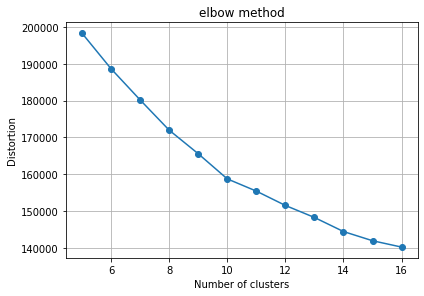

In [71]:
# Using elbow
from sklearn.cluster import KMeans
distortions = [ ]
for i in range(5, 17):
  km = KMeans(n_clusters=i, init='k-means++',  n_init=10, max_iter=300,  random_state=0)
  km.fit(X_train_s)
  distortions.append(km.inertia_)
plt.plot(range(5, 17), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.tight_layout()
plt.grid()
plt.title('elbow method')
plt.show()

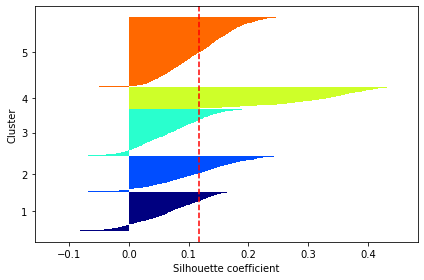

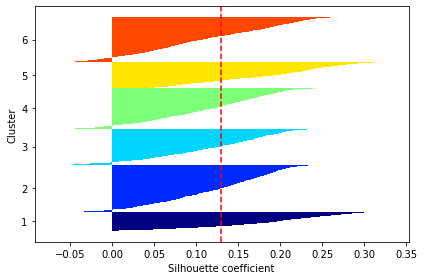

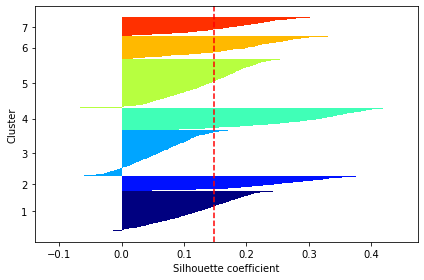

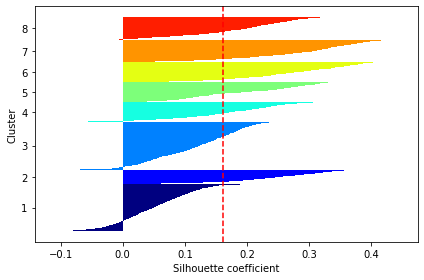

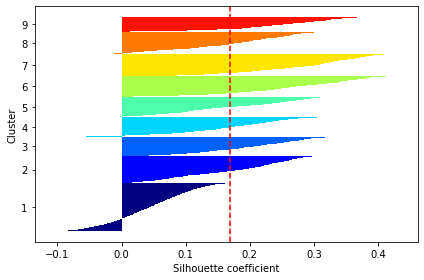

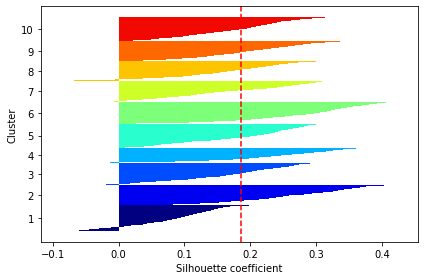

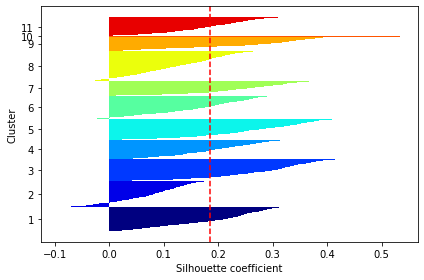

In [72]:
# Generate silhoutte plots for different ks and chose best K
import numpy as np
from matplotlib import cm
from sklearn.metrics import silhouette_samples
from sklearn.cluster import KMeans

for k in range(5,12):
  km = KMeans(n_clusters=k, init='k-means++', n_init=10, max_iter=300, tol=1e-04, random_state=0)
  y_km = km.fit_predict(X_train_s)
  cluster_labels = np.unique(y_km)
  n_clusters = cluster_labels.shape[0]
  silhouette_vals = silhouette_samples(X_train_s,y_km,metric='euclidean')
  y_ax_lower, y_ax_upper = 0,0
  yticks = []
  for i, c in enumerate(cluster_labels):
      c_silhouette_vals = silhouette_vals[y_km == c]
      c_silhouette_vals.sort()
      y_ax_upper += len(c_silhouette_vals)
      color = cm.jet(float(i) / n_clusters)
      plt.barh(range(y_ax_lower,y_ax_upper),c_silhouette_vals, height=1.0,edgecolor='none', color=color)
      yticks.append((y_ax_lower+y_ax_upper)/2.)
      y_ax_lower += len(c_silhouette_vals)
  silhouette_avg = np.mean(silhouette_vals)
  plt.axvline (silhouette_avg, color="red",linestyle="--")
  plt.yticks(yticks, cluster_labels + 1)
  plt.ylabel('Cluster')
  plt.xlabel('Silhouette coefficient')
  plt.tight_layout()
  plt.show()

In [73]:
# run kmeans
num_clusters = 10
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=num_clusters, random_state=10).fit(X_train_s)


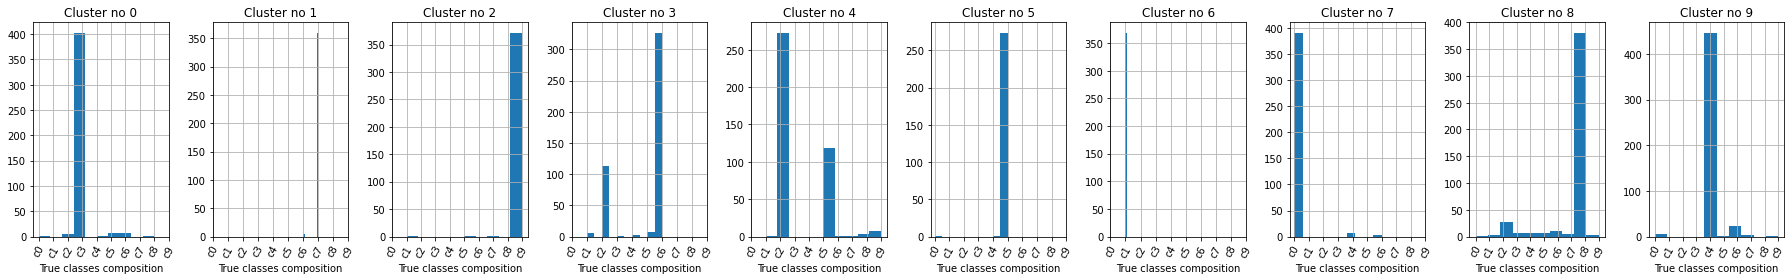

In [74]:
# Plot clustering results
import matplotlib.pyplot as plt
import numpy as np

labels = ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9']

plt.figure(figsize=(25,4))
for i in range(num_clusters):
  plt.subplot(1,num_clusters,i+1)
  plt.hist(y_train[np.where(kmeans.labels_==i)])
  plt.title('Cluster no '+str(i))
  plt.xlabel('True classes composition')
  plt.xticks(range(len(labels)),np.array(labels), rotation=60)
  plt.tight_layout()
  plt.grid()

In [75]:
# Use clustering to map the data

X_train_dist = kmeans.transform(X_train_s)
X_test_dist = kmeans.transform(X_test_s)
print("Distance feature shape: {}".format(X_train_dist.shape))

Distance feature shape: (4000, 10)


In [76]:
clf_kmeans = DecisionTreeClassifier(random_state=15, max_features='auto', max_depth=10, criterion='gini')

In [77]:
clf_kmeans.fit(X_train_dist,y_train)
print("Training  score = ", clf_kmeans.score(X_train_dist,y_train))
print(" Testing score = ", clf_kmeans.score(X_test_dist, y_test))

Training  score =  0.84075
 Testing score =  0.813


## Summary and comparison

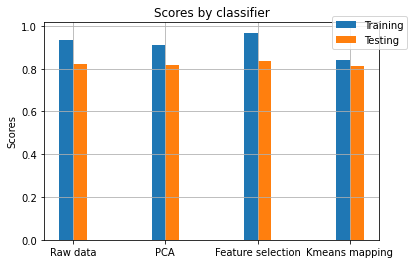

In [78]:
labels = ['Raw data', 'PCA', 'Feature selection', 'Kmeans mapping']
train_acc = [dt_clf.score(X_train, y_train), clf_pca.score(X_train_pca, y_train), clf_FS.score(X_train_l1,y_train), clf_kmeans.score(X_train_dist,y_train)]
test_acc = [dt_clf.score(X_test, y_test), clf_pca.score(X_test_pca, y_test), clf_FS.score(X_test_l1,y_test), clf_kmeans.score(X_test_dist, y_test)]

x = np.arange(len(labels))  # the label locations
width = 0.15  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, train_acc, width, label='Training')
rects2 = ax.bar(x + width/2, test_acc, width, label='Testing')

ax.set_ylabel('Scores')
ax.set_title('Scores by classifier')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(bbox_to_anchor=(1.1,1.05))
plt.grid()

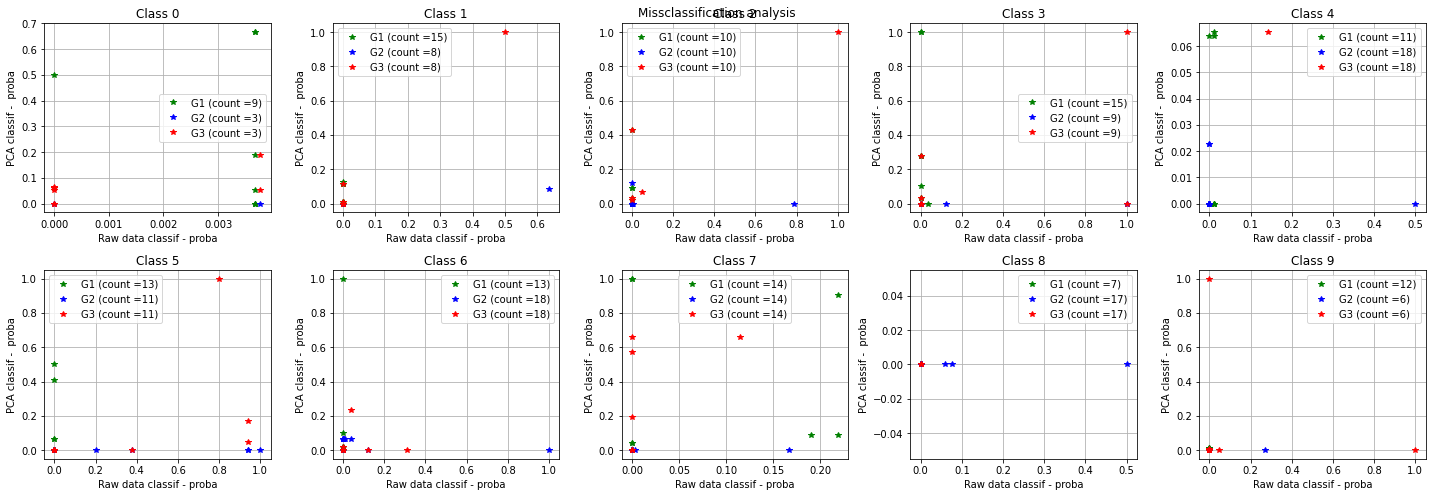

In [79]:
# Misclassification analysis
# Compare predict_probas

classifiers = [clf_pca, clf_FS, clf_kmeans]

rawCLF_pred = dt_clf.predict(X_test)
pcaCLF_pred = clf_pca.predict(X_test_pca)
plt.figure(figsize=(20,7))
plt.suptitle('Missclassification analysis')
for c in np.unique(y_test):
  plt.subplot(2,5,c+1)
  mask = y_test == c
  pcaCLF_pr = dt_clf.predict_proba(X_test)[mask,:]
  rawCLF_pr = clf_pca.predict_proba(X_test_pca)[mask,:]
  # G1: Samples misclassified by CLF2 and correctly classified by CLF1
  G1 = np.logical_and(pcaCLF_pred[mask] != y_test[mask], rawCLF_pred[mask] == y_test[mask]) 

  # G2: Samples misclassified by CLF1 and correctly classified by CLF2
  G2 = np.logical_and(pcaCLF_pred[mask] == y_test[mask], rawCLF_pred[mask] != y_test[mask]) 

  # G3: Samples misclassified by both
  G3 = np.logical_and(pcaCLF_pred[mask] != y_test[mask], rawCLF_pred[mask] != y_test[mask]) 
  plt.plot(pcaCLF_pr[G1,c-1],rawCLF_pr[G1,c-1],'g*',label='G1 (count ='+str(len(rawCLF_pr[G1,c-1]))+')')
  plt.plot(pcaCLF_pr[G2,c-1],rawCLF_pr[G2,c-1],'b*',label='G2 (count ='+str(len(rawCLF_pr[G2,c-1]))+')')
  plt.plot(pcaCLF_pr[G3,c-1],rawCLF_pr[G3,c-1],'r*',label='G3 (count ='+str(len(rawCLF_pr[G2,c-1]))+')')
  plt.title('Class '+str(c))
  plt.grid()
  plt.legend()
  plt.tight_layout()
  plt.xlabel('Raw data classif - proba')
  plt.ylabel('PCA classif -  proba')

* For most of the classes, the number of samples misclassified by CLF1 (using raw data) tend to be less than those of PCA classification.

* Missclassifications using the PCA tend to have lower confidences compared to PCA classifications (blue dots vs. green dots: C0, C1, C2..)

* In class 4, and class 9, there is almost an agreement between the two classifiers.

* PCA helps for classes like 8, and 6



### Visualize some misclassifications from each of the 10 classes: PCA vs. Raw data

In [80]:
# Generate predictions

rawCLF_pred = dt_clf.predict(X_test)
pcaCLF_pred = clf_pca.predict(X_test_pca)

# Ground truth labels: y_test

In [81]:
np.unique(y_test)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

######### True classes ###########


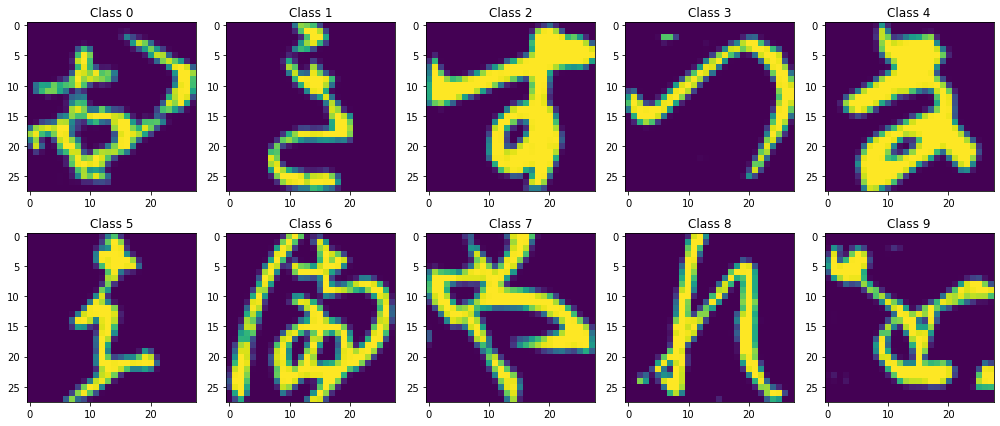

In [82]:
# plot a sample from each class
print('######### True classes ###########')
plt.figure(figsize=(14,6))
for c in np.unique(y_test):
  plt.subplot(2,5,c+1)
  idx = np.where(y_test == c)
  plt.imshow(img_test[idx[0][0]].reshape(28,28))
  plt.title('Class '+str(c))
  plt.tight_layout()


######### Samples of  misclassifications by DT+Raw data from each class ###########


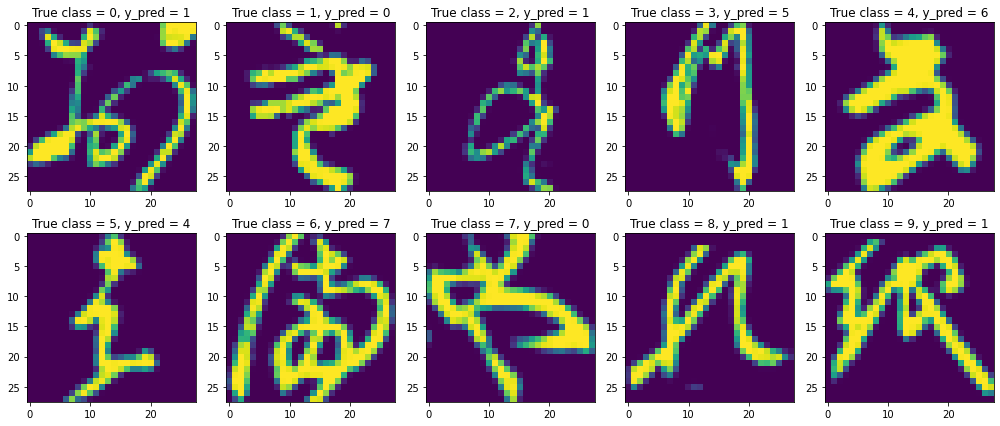

In [83]:
# plot a sample from each class
print('######### Samples of  misclassifications by DT+Raw data from each class ###########')
plt.figure(figsize=(14,6))
for c in np.unique(y_test):
  plt.subplot(2,5,c+1)
  mask = np.logical_and(y_test == c, rawCLF_pred != c)  #np.where(y_test == c)
  plt.imshow(img_test[mask,:][0].reshape(28,28))
  plt.title('True class = '+str(c) + ', y_pred = ' + str(rawCLF_pred[mask][0]))
  plt.tight_layout()

######### Samples of  misclassifications by DT+PCA data from each class ###########


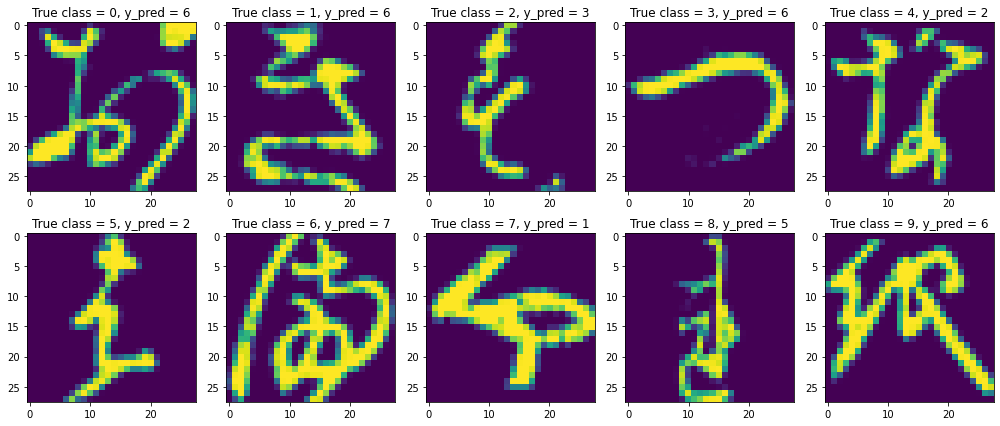

In [84]:
# plot a sample from each class
print('######### Samples of  misclassifications by DT+PCA data from each class ###########')
plt.figure(figsize=(14,6))
for c in np.unique(y_test):
  plt.subplot(2,5,c+1)
  mask = np.logical_and(y_test == c, pcaCLF_pred != c)  #np.where(y_test == c)
  plt.imshow(img_test[mask,:][0].reshape(28,28))
  plt.title('True class = '+str(c) + ', y_pred = ' + str(pcaCLF_pred[mask][0]))
  plt.tight_layout()

## More to explore

- Try for a different classifier: SVM, Random Forest..
- Vary the number of PCA components
- Do the same comparison for the other classification settings: Feature selection, kmeans mapping..
- Try for a different data